## Resumo do Capítulo 12: Applications in Communications

Este capítulo aborda aplicações de processamento de sinais em comunicações usando MATLAB, com foco em:

1. **Codificação de Formas de Onda**:
   - **PCM (Pulse-Code Modulation)**: Digitalização de sinais analógicos com quantização uniforme/não uniforme (leis μ/A).
   - **DPCM (Differential PCM)**: Explora correlação entre amostras para reduzir taxa de bits.
   - **ADPCM (Adaptive DPCM)**: Versão adaptativa que ajusta quantizador/preditor dinamicamente.
   - **DM/ADM (Delta Modulation)**: Versão simplificada com 1 bit e adaptação de passo.
   - **LPC (Linear Predictive Coding)**: Modela trato vocal como filtro IIR para compressão de voz.

2. **Comunicações Digitais**:
   - **Sistema Binário Básico**: Transmissão com pulsos retangulares em canal ruidoso.
   - **Spread-Spectrum**: Uso de sequências PN para combater interferência e permitir CDMA.
   - **Detecção DTMF**: Decodificação de tons de telefonia usando algoritmo de Goertzel.

3. **Projetos de Simulação**:
   - Implementação de codecs (PCM, DPCM, ADPCM, LPC).
   - Análise de desempenho (SQNR, BER).
   - Geração/detecção de tons DTMF.

---

### Simulações em Python

#### 1. PCM com Compressão μ-law


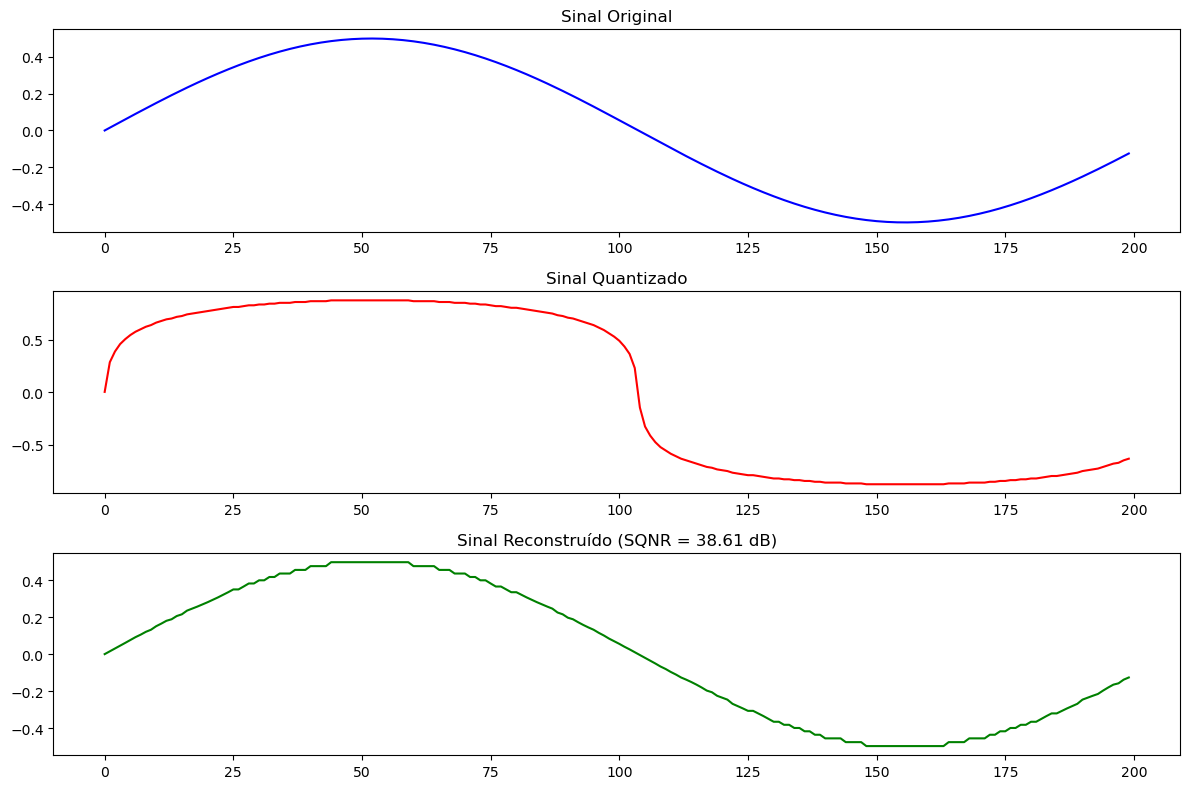

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def mu_law_compressor(s, mu=255):
    return np.sign(s) * np.log1p(mu * np.abs(s)) / np.log1p(mu)

def uniform_quantizer(x, b):
    levels = 2 ** b
    x_normalized = (x + 1) / 2  # Normaliza para [0, 1]
    x_quantized = np.round(x_normalized * (levels - 1)) / (levels - 1)
    return 2 * x_quantized - 1  # Retorna para [-1, 1]

def mu_law_expander(y, mu=255):
    return np.sign(y) * (1 / mu) * ((1 + mu) ** np.abs(y) - 1)

# Parâmetros
b_bits = 8
mu = 255
N = 10000
n = np.arange(N)

# Sinal senoidal (não periódico)
s = 0.5 * np.sin(n / 33)

# PCM completo
s_compressed = mu_law_compressor(s, mu)
s_quantized = uniform_quantizer(s_compressed, b_bits)
s_reconstructed = mu_law_expander(s_quantized, mu)

# Cálculo SQNR
error = s - s_reconstructed
sqnr = 10 * np.log10(np.sum(s**2) / np.sum(error**2))

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(n[:200], s[:200], 'b')
plt.title('Sinal Original')
plt.subplot(3, 1, 2)
plt.plot(n[:200], s_quantized[:200], 'r')
plt.title('Sinal Quantizado')
plt.subplot(3, 1, 3)
plt.plot(n[:200], s_reconstructed[:200], 'g')
plt.title(f'Sinal Reconstruído (SQNR = {sqnr:.2f} dB)')
plt.tight_layout()
plt.show()


#### 2. Detecção DTMF com Algoritmo de Goertzel

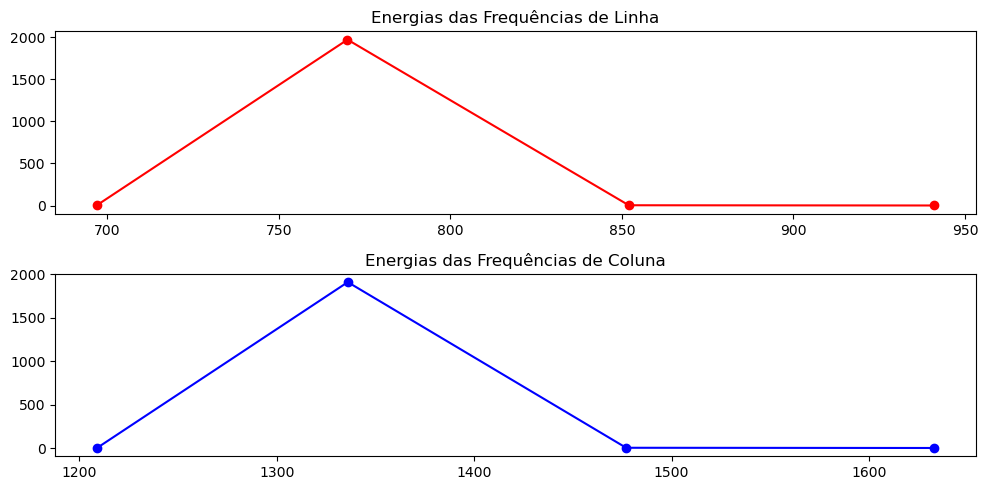

Tecla detectada: Linha 2, Coluna 2


In [4]:
def goertzel(x, target_freq, sample_rate):
    N = len(x)
    k = int(0.5 + (N * target_freq) / sample_rate)
    omega = 2 * np.pi * k / N
    coeff = 2 * np.cos(omega)
    
    v0, v1, v2 = 0, 0, 0
    for n in range(N):
        v0 = coeff * v1 - v2 + x[n]
        v2 = v1
        v1 = v0
    
    return np.sqrt(v1**2 + v2**2 - coeff * v1 * v2)

# Frequências DTMF (Hz)
rows = [697, 770, 852, 941]
cols = [1209, 1336, 1477, 1633]

# Geração de tom DTMF para '5' (770Hz + 1336Hz)
fs = 8000
t = np.linspace(0, 0.5, int(fs * 0.5))
digit = np.sin(2 * np.pi * 770 * t) + np.sin(2 * np.pi * 1336 * t)

# Detecção
row_energies = [goertzel(digit, f, fs) for f in rows]
col_energies = [goertzel(digit, f, fs) for f in cols]

# Plot resultados
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(rows, row_energies, 'ro-')
plt.title('Energias das Frequências de Linha')
plt.subplot(2, 1, 2)
plt.plot(cols, col_energies, 'bo-')
plt.title('Energias das Frequências de Coluna')
plt.tight_layout()
plt.show()

print(f"Tecla detectada: Linha {np.argmax(row_energies)+1}, Coluna {np.argmax(col_energies)+1}")


#### 3. Sistema Binário de Comunicação (BER Simulation)

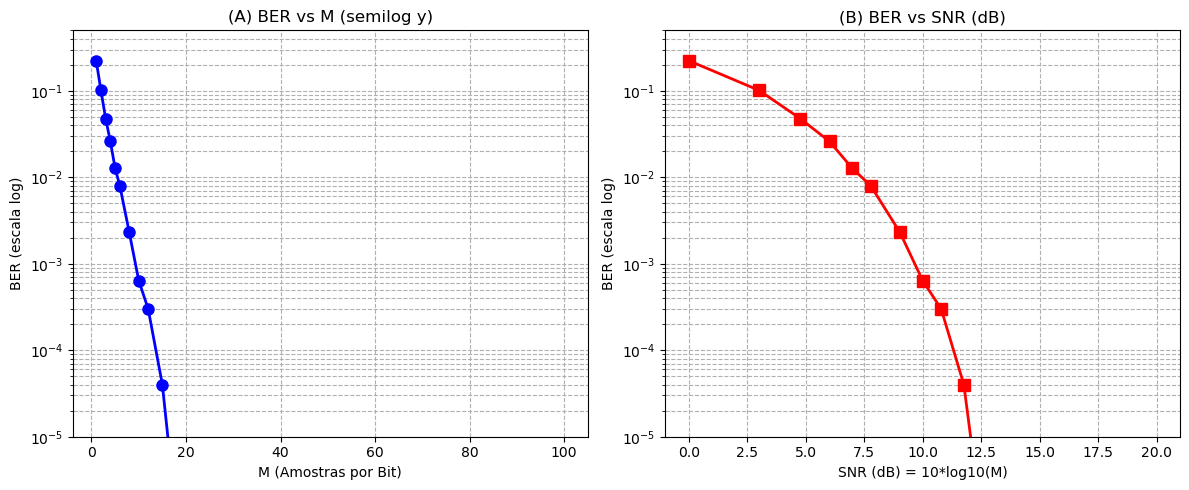

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def binary_comm_system(M, a, num_bits=50000):
    bits_tx = np.random.randint(0, 2, num_bits)
    s = (2 * bits_tx - 1).astype(np.float32)
    
    block_size = min(1000, num_bits)
    errors = 0
    
    for i in range(0, num_bits, block_size):
        bits_block = bits_tx[i:i+block_size]
        s_block = np.repeat(s[i:i+block_size], M)
        noise = np.random.uniform(-a, a, len(s_block)).astype(np.float32)
        r_block = s_block + noise
        
        r_blocks = r_block.reshape(-1, M)
        sums = np.sum(r_blocks, axis=1)
        bits_rx = (sums > 0).astype(int)
        errors += np.sum(bits_block != bits_rx)
    
    ber = errors / num_bits
    return max(ber, 1e-7)  

# Parâmetros
a = 1.8
M_values = np.unique(np.concatenate([
    np.linspace(1, 5, 5),
    np.linspace(6, 15, 5),
    np.linspace(20, 100, 6)
])).astype(int)

bers = [binary_comm_system(M, a) for M in M_values]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  
plt.semilogy(M_values, bers, 'b-o', linewidth=2, markersize=8)
plt.xlabel('M (Amostras por Bit)')
plt.ylabel('BER (escala log)')
plt.title('(A) BER vs M (semilog y)')
plt.grid(True, which='both', linestyle='--')
plt.ylim(1e-5, 0.5)

snr_db = 10 * np.log10(M_values)  # Conversão para dB
plt.subplot(1, 2, 2) 
plt.semilogy(snr_db, bers, 'r-s', linewidth=2, markersize=8)
plt.xlabel('SNR (dB) = 10*log10(M)')
plt.ylabel('BER (escala log)')
plt.title('(B) BER vs SNR (dB)')
plt.grid(True, which='both', linestyle='--')
plt.ylim(1e-5, 0.5)

plt.tight_layout()
plt.show()

# 🎥 Vídeos sobre o capítulo 12

## Vídeo 1 – Matlab DTMF Decoder Code
https://youtu.be/gWx3ymWYBsA

## Vídeo 2 – Differential Pulse Code Modulation DPCM Explained using MATLAB
https://www.youtube.com/watch?v=1kECblA_u2E

## Vídeo 3 – Pulse Code Modulation (PCM) Basic Elements
https://www.youtube.com/watch?v=bnP5Y2TVa_s